# Detecting Blindness with Deep Learning
> Using CNNs to detect diabetic retinopathy in retina photos.

- toc: true 
- badges: true
- comments: true
- author: Nikita Kozodoi
- categories: [jupyter]
- image: images/posts/retina.png

# 1. Overview

Can deep learning help to detect blindenss?

Diabetic retinopathy (DR) is one of the leading causes of vision loss. The World Health Organization reports that more than 300 million people worldwide have diabetes (Wong et al 2016). According to a recent study from International Diabetes Federation, the global prevalence of DR among the individuals with diabetes for the period from 2015 to 2019 was at more than 25% (Thomas et al 2019). The disease prevalence has been rising rapidly in developing countries.

Early detection and treatment are crucial steps towards preventing DR. The screening procedure requires a trained clinical expert to examine the fundus photographs of the patient's retina. This creates delays in diagnosis and treatment of the disease. This is especially relevant for developing countries, which often lack qualified medical stuff to perform the diagnosis. Automated detection of DR can speed up the efficiency and coverage of the screening programs.

This blogpost describes the pipeline of the project that develops a convolutional neural network (CNN) for predicting the severity of DR disease based on the patient's retina photograph. The project was completed within the scope of the Udacity Machine Learning Engineer program and the Kaggle competition hosted by the Asia Pacific Tele-Ophthalmology Society (APTOS). The blogpost covers such steps as:

- data exploration and preprocessing to normalize images from different clinics
- using transfer learning to pre-train a CNN on a large data set and fine-tune the model on target data
- implementing techniques such as learnung rate scheduler, test-time augmentation and others to improve the performance

The codes for this project and a PDF report are available on Github. The modeling is done using PyTorch.

# 2. Data preparation

Data exploration and preprocessing is very important step that is frequently underestimated. The quality of the input data directly impact the resulting performance of the machine learning models bult on theat data. Therefore, it is crucial to take some time to look at the data and think about possible issues that should be addressed before moving on to the modeling stage.

## 2.1. Data exploration

The data set is provided by APTOS and is available for the download at the [competition's website](https://www.kaggle.com/c/aptos2019-blindness-detection/data). The data set includes 3,662 labeled retina images of clinical patients and a test set with 1,928 images. 

The images are taken using a fundus photography technique and labeled by a clinical expert. The integer labels indicate the severity of DR on a scale from 0 to 4, where 0 indicates no disease and 5 is the proliferative stage of DR.

First, let us import the data and looak at the class ditribution.

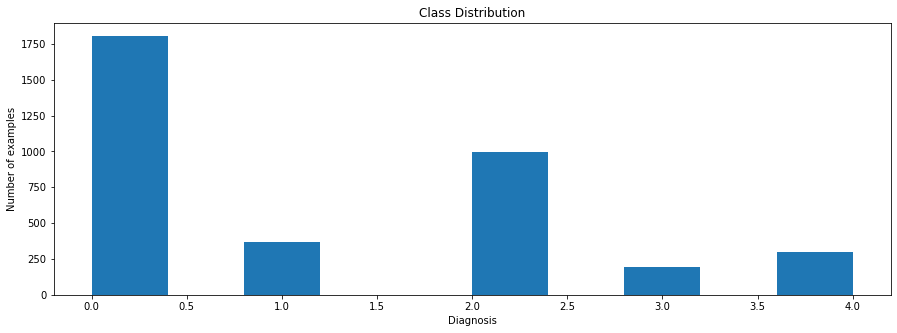

In [4]:
#collapse-hide

############ LIBRARIES

import numpy as np
import pandas as pd

import torch
import torchvision

from torchvision import transforms, datasets
from torch.utils.data import Dataset

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from tqdm import tqdm_notebook as tqdm

import random
import time
import sys
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns



########## SETTINGS

pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')



############ CHECK DIMENSIONS

# import data
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test  = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

# check shape
print(train.shape, test.shape)
print('-' * 15)
print(train['diagnosis'].value_counts(normalize = True))



############ CLASS DISTRIBUTION

# plot
fig = plt.figure(figsize = (15, 5))
plt.hist(train['diagnosis'])
plt.title('Class Distribution')
plt.ylabel('Number of examples')
plt.xlabel('Diagnosis')

# export
plt.savefig('fig_class_distribution.pdf')

The data set is imbalanced. 49% of the images are healthy patients. The remaining 51\% are pictures with different stages of DR. The least common class is 3 (severe stage) with only 5% of the total examples.

The data is collected from multiple clinics in India using a variety of different camera models, which creates discrepancies in the image resolution, aspect ratio and other parameters. This is demonstrated in the fogire below, where we plot the histograms of image width, height and aspect ratio. A high variety in the image parameters requires to be accounted for during the data prepossessing.

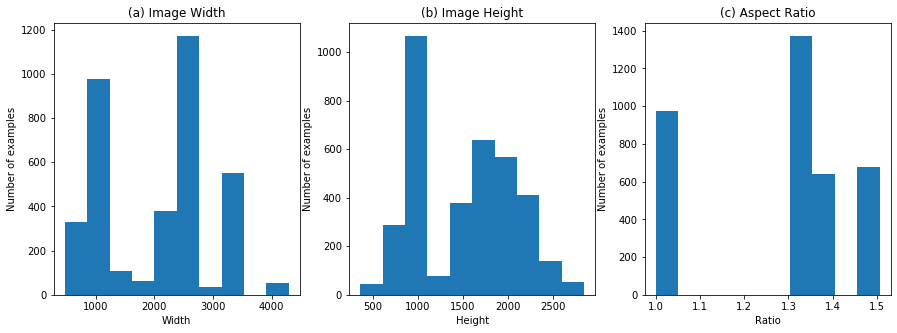

In [8]:
#collapse-hide

############ IMAGE SIZES

# placeholder
image_stats = []

# import loop
for index, observation in tqdm(train.iterrows(), total = len(train)):
    
    # import image
    img = cv2.imread('../input/aptos2019-blindness-detection/train_images/{}.png'.format(observation['id_code']))

    # compute stats
    height, width, channels = img.shape
    ratio = width / height
    
    # save
    image_stats.append(np.array((observation['diagnosis'], height, width, channels, ratio)))

# construct DF
image_stats = pd.DataFrame(image_stats)
image_stats.columns = ['diagnosis', 'height', 'width', 'channels', 'ratio']



############ IMAGE SIZE DISTRIBUTION

fig = plt.figure(figsize = (15, 5))

# width
plt.subplot(1, 3, 1)
plt.hist(image_stats['width'])
plt.title('(a) Image Width')
plt.ylabel('Number of examples')
plt.xlabel('Width')

# height
plt.subplot(1, 3, 2)
plt.hist(image_stats['height'])
plt.title('(b) Image Height')
plt.ylabel('Number of examples')
plt.xlabel('Height')

# ratio
plt.subplot(1, 3, 3)
plt.hist(image_stats['ratio'])
plt.title('(c) Aspect Ratio')
plt.ylabel('Number of examples')
plt.xlabel('Ratio')

# export
plt.savefig('fig_size_distribution.pdf')

Now, let us take a look at the actual images. The code below creates the `EyeData` dataset class to import the images using `opencv` library. We also create a `DataLoader` object to load sample images and visualize the first batch.

In [ ]:
#collapse-hide

############ DATASET

# image preprocessing function
def prepare_image(path, image_size = 256):
    
    # import
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resize
    image = cv2.resize(image, (int(image_size), int(image_size)))

    # convert to tensor    
    image = torch.tensor(image)
    image = image.permute(2, 1, 0)
    return image
  
    
# dataset class:
class EyeData(Dataset):
    
    # initialize
    def __init__(self, data, directory, transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform
        
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'id_code'] + '.png')
        image    = prepare_image(img_name)  
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'diagnosis'])
        return {'image': image, 'label': label}
    
    
    
############ EXAMINE SAMPLE BATCH

# transformations
sample_trans = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                  ])

# dataset
sample = EyeData(data       = train, 
                 directory  = '../input/aptos2019-blindness-detection/train_images',
                 transform  = sample_trans)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = 10, 
                                            shuffle     = False, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (15, 7))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, len(labels)/2, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

# export plot
plt.savefig('fig_data_example.pdf')

#hide_input

![](images/fig_data_example.pdf)